Recently, a friend recommended me a book, [Deep Learning with Python] by Francois Chollet. As an eager learner just starting to fiddle with the Keras API, I decided it was a good starting point. I have just finished the first section of Part 2 on Convolutional Neural Networks and image processing. My impression so far is that the book is more focused on code than math. The apparent advantage of this approach is that it shows readers how to build neural networks very transparently. It's also a good introduction to many neural network models, such as CNNs or LSTMs. On the flip side, it might leave some readers wondering why these models work, concretely and mathematically. This point notwithstanding, I've been enjoying the book very much so far, and this post is a reflection of just that. 

Today, we will use TensorFlow's `tf.keras` module to build a convolutional neural network for image detection. This code is based on what I have learned from the book, so much credit goes to [Deep Learning with Python]. I have also looked at [Machine Learning Mastery blog] for additional reference. Let's begin!

# Data Preparation

Below are the modules that we will need to import for this demonstration. Note that this Jupyter Notebook was written on Google Colaboratory. 

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, callbacks, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('seaborn')

The `load_dataset` function loads the CIFAR10 data set from `tensforflow.keras.datasets` module, then applies some basic preprocessing to make it more usable for deep learning purposes. The CIFAR10 data set contains 50000 training images, each labeled with 1 of 10 classes, ranging from cats, horses, and trucks to airplanes. This is a classic classification task. The preprocessing occurs on two levels: first, the images are normalized so that its pixels takes values between 0 and 1. The training labels are transformed from an integer class label to a one-hot encoded vector. Let's load the data to proceed with our analysis.


In [0]:
def load_dataset(validation_size=0.1):
  (X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
  X_train, X_test = X_train.astype('float32') / 255.0, X_test.astype('float32') / 255.0
  y_train, y_test = utils.to_categorical(y_train), utils.to_categorical(y_test)
  num_val = int(validation_size * len(y_train))
  X_val, X_train = X_train[:num_val], X_train[num_val:]
  y_val, y_train = y_train[:num_val], y_train[num_val:]
  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

Let's see what the dimensions of the data are. Because the CIFAR10 data set include color images for its training set, we would expect three channels, each corresponding to red, green, and blue (hence RGB). As expected, it appears that the training data is a tensor of four dimensions, while the target labels are 10 dimensional vectors. 

In [0]:
y_val.shape

(5000, 10)

In [0]:
X_train.shape

(45000, 32, 32, 3)

To get a better idea of what the CIFAR10 data looks like, here is a basic function that will display the images in the data set for us using `matplotlib.pyplot`. We can see that, although the images are very pixelated, it is somewhat possible to make out what each image is showing. Of course, this task is going to be a lot more difficult for our neural network. 

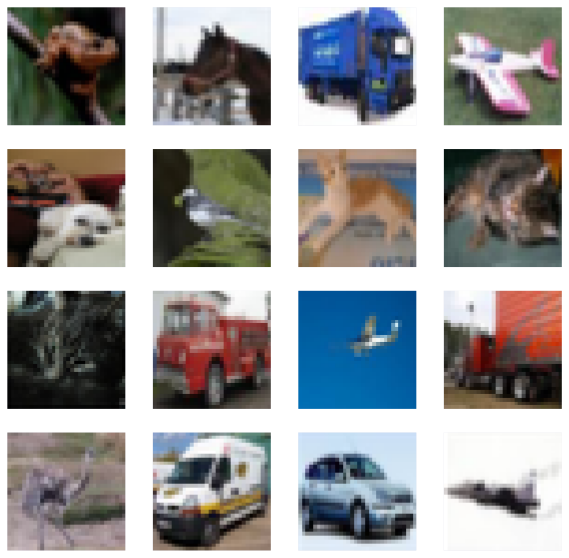

In [0]:
def show_image(data, row_num=4):
  num_image = row_num**2
  plt.figure(figsize=(10,10))
  for i in range(num_image):
    plt.subplot(row_num,row_num,i+1)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    plt.imshow(data[i], cmap=plt.cm.binary)
  plt.show()

show_image(X_train)

Now is finally the time to buid the neural network. This network pretty much follows the standard vanilla convolutional neural network model, which typically involves stacking convolution, batch normalization, and pooling layers on top of each other. The dropout layers were also added so as to minimize any potential overfitting. The `kernel_initializer` argument was configured as `he_uniform`, named after Kaiming He who found the optimal weight initialization kernel for convolutional layers. The `padding` argument ensures that the the feature maps are not downsized too quickly due to repeated applications of convolution and pooling. The `BatchNormalization` layer simply normalizes the tensor returned from the previous layer. There are ongoing research as to what effect batch normalization has on neural networks, but the general consensus is that it helps the model learn more quickly and efficiently. The `build_model` function returns the predefined sequential model, compiled using the configurations as shown below.  

In [0]:
def build_model():
  model = models.Sequential(
    [layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
     layers.BatchNormalization(),
     layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2, 2)),
     layers.Dropout(0.2),
     layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2, 2)),
     layers.Dropout(0.3),
     layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D((2, 2)),
     layers.Dropout(0.4),
     layers.Flatten(),
     layers.Dense(128, activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.5),
     layers.Dense(10, activation='softmax')
     ])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Let's take a look at the summary of the model. The summary shows that this model has 551,466 trainable parameters. The memory capacity of this model is not big, but it is definitely larger than the network we built in the [previous post] using the Keras API. 

In [0]:
model = build_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________

Now that the model is ready to be deployed, we need to train and test the model. But before that, let's quickly define a function that will provide us with a visualization of how the model is learning. This function is very similar to the one used in the previous post---all it does it that it plots the model's accuracy and cross entropy loss with each epoch. This visualization will help us see whether our model is actually learning with each epoch, and whether or not overfitting is occurring at any point in training. 

In [0]:
def show_learning_curve(history):
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'])
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Cross Entropy Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'])
  plt.tight_layout()
  plt.show()

The last piece of the puzzle we need is the `test_model` function. This function is essentially wraps all the functions we have created previously, first by loading the data, training using that data, building a model, training a model, and calling on the `show_learning_curve` function to provide a visualization of the model's learning curve. One minor tweak I used to spice up this function is the `ImageDataGenerator`, which basically creates more images for the neural network to train on by slightly modifying existing images in the training set. These modifications involve shifting, zooming, and flipping. When we don't have enough data to train our model on, using the `ImageDataGenerator` can be useful.

In [0]:
def test_model():
  X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
  datagen = ImageDataGenerator(
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
  train_data = datagen.flow(
      X_train, 
      y_train, 
      batch_size=64, 
      shuffle=True)
  model = build_model()
  history = model.fit(
      train_data,
      epochs=50, 
      validation_data=(X_val, y_val),
      callbacks=[callbacks.EarlyStopping(patience=5)],
      verbose=2)
  _, acc = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy: {}%".format(acc * 100))
  show_learning_curve(history)

Finally, let's see how well our model performs!

Epoch 1/50
Epoch 1/50
5000/704 - 1s - loss: 1.4018 - acc: 0.4452
704/704 - 24s - loss: 1.9197 - acc: 0.3393 - val_loss: 1.5981 - val_acc: 0.4452
Epoch 2/50
Epoch 1/50
5000/704 - 1s - loss: 1.3273 - acc: 0.5178
704/704 - 22s - loss: 1.4458 - acc: 0.4765 - val_loss: 1.4521 - val_acc: 0.5178
Epoch 3/50
Epoch 1/50
5000/704 - 1s - loss: 0.9988 - acc: 0.5868
704/704 - 22s - loss: 1.2782 - acc: 0.5444 - val_loss: 1.1961 - val_acc: 0.5868
Epoch 4/50
Epoch 1/50
5000/704 - 1s - loss: 1.2566 - acc: 0.5264
704/704 - 21s - loss: 1.1569 - acc: 0.5904 - val_loss: 1.5175 - val_acc: 0.5264
Epoch 5/50
Epoch 1/50
5000/704 - 1s - loss: 1.0085 - acc: 0.6482
704/704 - 22s - loss: 1.0686 - acc: 0.6256 - val_loss: 1.0519 - val_acc: 0.6482
Epoch 6/50
Epoch 1/50
5000/704 - 1s - loss: 0.9098 - acc: 0.6940
704/704 - 22s - loss: 0.9966 - acc: 0.6506 - val_loss: 0.8696 - val_acc: 0.6940
Epoch 7/50
Epoch 1/50
5000/704 - 1s - loss: 1.0636 - acc: 0.6506
704/704 - 22s - loss: 0.9380 - acc: 0.6744 - val_loss: 1.0681 - v

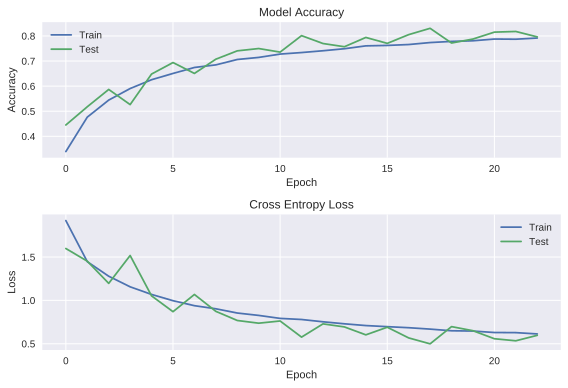

In [0]:
test_model()

The result shows that the model has learned decently well, with testing accuracy of approximately 80 percent. This is not the best result, but it is certainly not bad, especially given the fact that the images in the dataset, as we have seen above, are very pixelated and sometimes difficult for even humans to decipher and categorize. 

That's all for today. It's fascinating to see how CNNs are capable of perceiving images and categorizing them after appropriate training. But as we all know, the potential of neural networks far extends beyond image classificaiton. In a future post, we might look at more complicated models, such as RNN or LSTMs, to achieve even cooler tasks. 

Happy lunar new year!

[Deep Learning with Python]: https://www.manning.com/books/deep-learning-with-python
[Machine Learning Mastery blog]: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
[previous post]: https://jaketae.github.io/study/first-keras/